In [49]:
!pip install -r requirements.txt
!pip uninstall -y tinarm
!pip install -e ../.

  Cloning https://github.com/TinArmEngineering/tinarm.git (to revision 0.1.89) to /tmp/pip-req-build-a1yn7cr3
  Running command git clone --filter=blob:none --quiet https://github.com/TinArmEngineering/tinarm.git /tmp/pip-req-build-a1yn7cr3
  Running command git checkout -q 64b54d6b6ae15b805f347ee865df7811d6a8d3a1
  Resolved https://github.com/TinArmEngineering/tinarm.git to commit 64b54d6b6ae15b805f347ee865df7811d6a8d3a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tinarm: filename=tinarm-0.1-py3-none-any.whl size=8398 sha256=c332b8d59780ea13351c5e48360d5178fbdb64d1e80f2a204c3f7674ae66cafe
  Stored in directory: /tmp/pip-ephem-wheel-cache-z8l4yeb8/wheels/00/4c/e3/4b3aa36f9a510bb151617615ac0ee6a290203b67d99510c06c
Successfully built tinarm
  Attempting uninstall: tinarm
    Found existing installation: tinarm 0.1
    Uninstalling tinar

In [50]:
import matplotlib.pyplot as plt
import pint
# from tinarm import NameQuantityPair
# from tinarm import Quantity 
from tinarm import Job
from tinarm import Machine
from tinarm.api import JOB_STATUS
from tinarm import Api

import logging
import time
import requests
import uuid
import random
import yaml
import pandas as pd
import pint_pandas
import numpy as np


In [51]:

LOGGING_LEVEL = logging.INFO
STATUS_JOB = {value:key for key,value in JOB_STATUS.items()}

In [52]:

### Configure Logging
logger = logging.getLogger()
logger.setLevel(LOGGING_LEVEL)
#logger.info(f"tinarm version {tinarm.__version__}")
logger.info(f"pint_pandas version {pint_pandas.__version__}")

q = pint_pandas.PintType.ureg
q.setup_matplotlib()

2024-03-12 19:24:30,678 - NoJobId - INFO - Kebnekaise - 138153749.py-><module>() - pint_pandas version 0.5


Log in to Tin Arm Engineering's machine solver, and under profile, retrieve your API key. 
Do not commit your API key to a repository, and consider it like a password.  A good way to keep it out of this code base is to use a configuation file, or environment variable. We will want other things cofigured too, so let's use a yaml file for convenience. 

create a `configurations.yaml` file in this directory with the content.
```yaml
api_key: 668952058c490d0a296da0abb966****
root_url: http://server-go:4300
```
But of course replace the number with your api key

You can then add that file to your `.gitignore` file by executing ```echo 'configurations.yaml' >> .gitignore```

```
!echo 'configurations.yaml' >> .gitignore
```

In [53]:
with open("configurations.yaml", "r") as f:
    config = yaml.safe_load(f)

# Stator

In [54]:
stator_parameters = {
    "slot_liner_thikness": 300 * q.um,
    "stator_bore": 8.20 * q.cm,
    "tooth_tip_depth": 1.0 * q.mm,
    "slot_opening": 1.5 * q.mm,
    "tooth_width": 9.8 * q.mm,
    "stator_outer_diameter": 0.136 * q.m,
    "back_iron_thickness": 5.5 * q.mm,
    "stator_internal_radius": 500 * q.um,
    "number_slots": 12 * q.count,
    "tooth_tip_angle": 70 * q.degrees
    }

air_gap_length = 1 * q.mm

## Rotor
Surface mounted Breadloaf magnets

In [55]:
rotor_parameters = {
    "rotor_od": stator_parameters["stator_bore"] - 2 * air_gap_length,
    "rotor_bore": 40 * q.mm,
    "banding_thickness": 0.5 * q.mm,
    "number_poles": 10 * q.count,
    "magnet_thickness": 4.5 * q.millimeter,
    "magnet_pole_arc": 150 * q.degrees,
    "magnet_inset": 0.25 * q.millimeter
    }

## Simulation Parameters

In [56]:
simulation_parameters = {
       "samples_per_electrical_period": 180 * q.count/q.turn,
        "timestep_intervals": 180 * q.count,
        "active_length": 65 * q.mm * 0.97}


In [57]:
winding_parameters = {
    "symmetry": 2 * q.count,
    "number_phases": 3 * q.count,
    "number_layers": 2 * q.count,
    "coil_span": 1 * q.count,
    "turns_per_coil": 43 * q.count,
    "empty_slots": 0 * q.count,
    "fill_factor": 42 * q.percent
    }

## Operating Point

In [58]:
op_open_cct = {
    "simulated_speed": 2060 * q.rpm,
    "current_density": 0 * q.A / q.mm ** 2,
    "current_angle": 0 * q.degrees
    }

op_nominal = {
    'current_density': 6.23 * q.A * q.mm**-2,
    'current_angle': 255 * q.degrees,
    "simulated_speed": 2060 * q.rpm
    }

In [59]:
api = Api(config["root_url"], config["api_key"], config["org_id"])

2024-03-12 19:24:30,832 - NoJobId - INFO - Kebnekaise - api.py->__init__() - root_url: https://api.build.tinarmengineering.com


In [60]:
m1 = Machine(stator_parameters, rotor_parameters, winding_parameters)

j1 = Job(m1, op_open_cct, simulation_parameters)
j1_result = api.create_job(j1)



In [61]:

j2 = Job(m1, op_nominal, simulation_parameters)
j2_result = api.create_job(j2)

In [62]:
assert j1.id != j2.id


In [63]:
j1_result = api.update_job_status(j1.id, JOB_STATUS['QueuedForMeshing'])
j2_result = api.update_job_status(j2.id, JOB_STATUS['QueuedForMeshing'])

while STATUS_JOB[api.get_job(j1.id)['status']] != 'Complete' or STATUS_JOB[api.get_job(j2.id)['status']] != 'Complete':
    print("job 1 {0} \t job 2 {1}".format(STATUS_JOB[api.get_job(j1.id)['status']], STATUS_JOB[api.get_job(j2.id)['status']] ))
    time.sleep(10)
time.sleep(1)

2024-03-12 19:24:33,004 - NoJobId - INFO - Kebnekaise - api.py->update_job_status() - Updating job status: https://api.build.tinarmengineering.com/jobs/65f09ddf716bd9766a2896c6/status/10?node_id=None&apikey=f3655d31edd9a0a90fd00d5064c8bfb2
2024-03-12 19:24:33,293 - NoJobId - INFO - Kebnekaise - api.py->update_job_status() - Updating job status: https://api.build.tinarmengineering.com/jobs/65f09de0716bd9766a2896c7/status/10?node_id=None&apikey=f3655d31edd9a0a90fd00d5064c8bfb2
job 1 Meshing 	 job 2 Meshing
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solving 	 job 2 Solving
job 1 Solv

In [64]:
j1_result = api.get_job(j1.id)
for artifact in j1_result['artifacts']:
    print(artifact['type'], artifact['url'], artifact['id'])

GMSH_MESH file://tae-cl00//app/job-data/65f09ddf716bd9766a2896c6/case.msh 3397d20191ae7331b7a09054
ELMER_SIF file://tae-cl00//app/job-data/65f09ddf716bd9766a2896c6/case.sif 603456b331e65d6968c3340d
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65f09ddf716bd9766a2896c6/results/step_t0001.vtu 83baff03e7b3f9109f434a65
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65f09ddf716bd9766a2896c6/results/step_t0180.vtu a7717d56acc3477900dd6f69
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65f09ddf716bd9766a2896c6/postprocess/FluxPlot.gif 8614da87fe4d2bd801adf7d4
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65f09ddf716bd9766a2896c6/postprocess/Torque.png 8b8f7d9255b7528eae5de222
RESULT_PLOT file://tae-cl00//app/job-data/65f09ddf716bd9766a2896c6/postprocess/Currents.png 6ef88c8b00cfbed08f6f2968
RESULT_PLOT file://tae-cl00//app/job-data/65f09ddf716bd9766a2896c6/postprocess/FluxLinkage.png ad91d5f4e51b27f58d

In [65]:
j1_result_data = [art for art in j1_result['artifacts'] if art['type']=='RESULT_DATA'][0]
j1_df = pd.read_csv(j1_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)

In [66]:
!ls M1/Nominal_24Nm_2060rpm/BackEmf.csv

M1/Nominal_24Nm_2060rpm/BackEmf.csv


In [67]:
#load M1 results for the nominal operation point
m1_op1_results = pd.read_csv("M1/Nominal_24Nm_2060rpm/BackEmf.csv", header=[0, 1])



In [84]:
offset = np.pi - np.deg2rad(2.5)


In [85]:
np.rad2deg(j1_df['angles'])

0    0.0      0.0
1    0.0      2.0
2    0.0      4.0
3    0.0      6.0
4    0.0      8.0
            ...  
175  0.0    350.0
176  0.0    352.0
177  0.0    354.0
178  0.0    356.0
179  0.0    358.0
Name: angles, Length: 180, dtype: float64

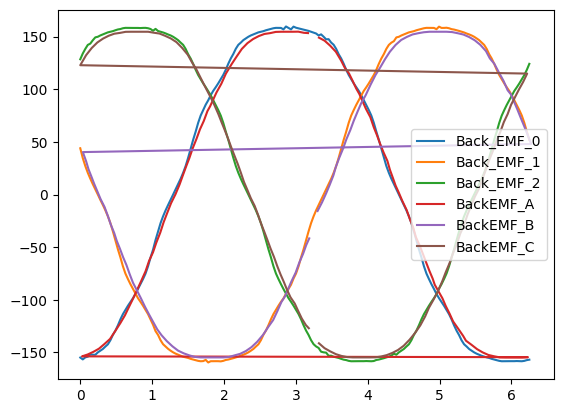

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(j1_df['angles'], j1_df['Back_EMF_0'], label='Back_EMF_0')
ax.plot(j1_df['angles'], j1_df['Back_EMF_1'], label='Back_EMF_1')
ax.plot(j1_df['angles'], j1_df['Back_EMF_2'], label='Back_EMF_2')
ax.plot((np.deg2rad(m1_op1_results['EMFa']['X'])*5 + offset) % (2*np.pi), m1_op1_results['EMFa']['Y'], label='BackEMF_A')
ax.plot((np.deg2rad(m1_op1_results['EMFb']['X'])*5 + offset) % (2*np.pi), m1_op1_results['EMFb']['Y'], label='BackEMF_B')
ax.plot((np.deg2rad(m1_op1_results['EMFc']['X'])*5 + offset) % (2*np.pi), m1_op1_results['EMFc']['Y'], label='BackEMF_C')
ax.legend()

In [71]:
# find the anqular offset between the two datasets
# convolution of 


In [72]:
j2_result = api.get_job(j2.id)
for artifact in j2_result['artifacts']:
    print(artifact['type'], artifact['url'], artifact['id'])
time.sleep(1)    

GMSH_MESH file://tae-build//app/job-data/65f09de0716bd9766a2896c7/case.msh f0955f6943b3173f3dde45d6
ELMER_SIF file://tae-build//app/job-data/65f09de0716bd9766a2896c7/case.sif 5b2ed76d5b017e802e6e2444
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65f09de0716bd9766a2896c7/results/step_t0001.vtu 450b251708f1e3a920da6f3e
VTU file https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65f09de0716bd9766a2896c7/results/step_t0180.vtu 99e26d2ac2daf858b6922ff3
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65f09de0716bd9766a2896c7/postprocess/FluxPlot.gif cb54387e391e3993e01bceb3
RESULT_PLOT https://lonely-tool-cult-build.s3.eu-north-1.amazonaws.com/65f09de0716bd9766a2896c7/postprocess/Torque.png 7a9340b92587577bd8b84f55
RESULT_PLOT file://tae-build//app/job-data/65f09de0716bd9766a2896c7/postprocess/Currents.png 41370703d5d52b471b707bec
RESULT_PLOT file://tae-build//app/job-data/65f09de0716bd9766a2896c7/postprocess/FluxLinkage.png 70a06fac1ae6a5

In [73]:
j2_result_data = [art for art in j2_result['artifacts'] if art['type']=='RESULT_DATA'][0]
j2_df = pd.read_csv(j2_result_data['url'], header=[0, 1], index_col=[0, 1]).pint.quantify(level=-1)

#load M1 results for the nominal operation point
#load M1 results for the nominal operation point
m1_op1_pv = pd.read_csv("M1/Nominal_24Nm_2060rpm/PhaseVoltage.csv", header=[0, 1])

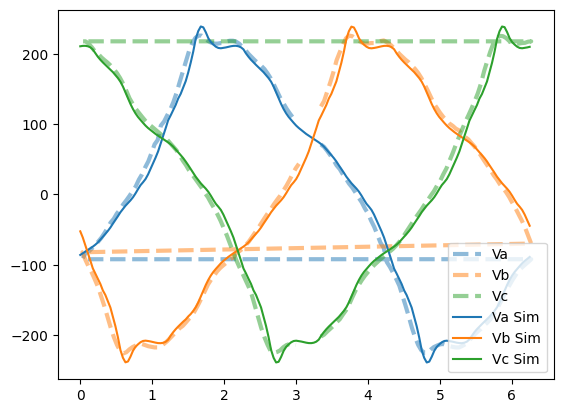

In [74]:
offset = np.pi *0.94
fig = plt.figure()
ax = fig.add_subplot(111)
l1, = ax.plot((np.deg2rad(m1_op1_pv['Va']['X'])*5 + offset) % (2*np.pi), m1_op1_pv['Va']['Y'], label='Va', 
              linewidth=3, linestyle='--', alpha=0.5)
l2, = ax.plot((np.deg2rad(m1_op1_pv['Vb']['X'])*5 + offset) % (2*np.pi), m1_op1_pv['Vb']['Y'], label='Vb',
              linewidth=3, linestyle='--', alpha=0.5)
l3, = ax.plot((np.deg2rad(m1_op1_pv['Vc']['X'])*5 + offset) % (2*np.pi), m1_op1_pv['Vc']['Y'], label='Vc',
              linewidth=3, linestyle='--', alpha=0.5)
ax.plot(j2_df['angles'], j2_df['Back_EMF_0'], label='Va Sim', color=l1.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_1'], label='Vb Sim', color=l2.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_2'], label='Vc Sim', color=l3.get_color())
ax.legend()

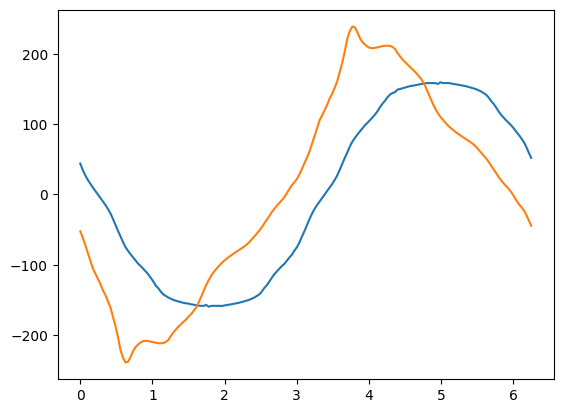

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(j1_df['angles'], j1_df['Back_EMF_1'], label='Back_EMF_1')
ax.plot(j2_df['angles'], j2_df['Back_EMF_1'], label='Back_EMF_1')

In [76]:
j2_df

,,Electromagnetic Field Energy,Fourier Loss Total,Fourier Loss 1,Fourier Loss 2,Air Gap Torque,Inertial Volume,Inertial Moment,angles,Scaled Torque,Back_EMF_0,Back_EMF_1,Back_EMF_2
0,0.0,104.2481539154,0.0,0.0,0.0,185.4167454352,0.0,0.0,0.000000,23.38105159937872,-86.032745,-52.431506,210.847855
1,0.0,104.3373195555,0.0,0.0,0.0,185.4301933794,0.0,0.0,0.034907,23.382747385142338,-83.723057,-61.212243,211.427677
2,0.0,104.4523075462,0.0,0.0,0.0,185.7492636192,0.0,0.0,0.069813,23.42298214238112,-81.409128,-72.033970,211.511226
3,0.0,104.5649620707,0.0,0.0,0.0,186.2396776834,0.0,0.0,0.104720,23.48482335587674,-78.951441,-82.953173,210.908565
4,0.0,104.6631213235,0.0,0.0,0.0,186.7333746597,0.0,0.0,0.139626,23.547078544588167,-76.568394,-93.939182,209.433466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.0,104.1781251386,0.0,0.0,0.0,188.7757518858,0.0,0.0,6.108652,23.804622312799378,-101.918635,-17.373195,208.485552
176,0.0,104.1519125343,0.0,0.0,0.0,187.8516275798,0.0,0.0,6.143559,23.68809023781278,-98.001936,-21.958304,208.033901
177,0.0,104.1474049326,0.0,0.0,0.0,187.0176436123,0.0,0.0,6.178466,23.58292485951103,-94.701264,-28.542171,208.553879
178,0.0,104.1601834196,0.0,0.0,0.0,186.2859485813,0.0,0.0,6.213372,23.490658116101933,-91.831618,-36.559172,209.220584


NameError: name 'm1_op1_tq' is not defined

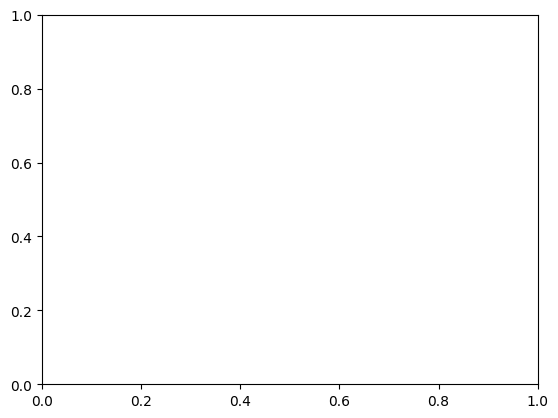

In [77]:

fig = plt.figure(2)
ax = fig.add_subplot(111)
l1, = ax.plot((np.deg2rad(m1_op1_tq['Torque']['X'])*5 + offset) % (2*np.pi), m1_op1_tq['Torque']['Y'], label='nominal Torque', 
              linewidth=3, linestyle='--', alpha=0.5)
l2, = ax.plot(j2_df['angles'], j2_df['Scaled Torque'], label='nominal Scaled Torque')
mean_torque = j2_df['Scaled Torque'].mean()
ax.axhline( mean_torque, label=f'Scaled Torque {mean_torque:2.4~P}', linestyle='--')
target_torque = 24.26 * q.N * q.m
ax.axhline( target_torque, label=f'Target {target_torque:2.4~P}', color='k', linestyle='--')

ax.legend()

In [ ]:
m1_df = pd.read_csv("Machine_Back_emfs_Machine_1.csv", skiprows=1, header=[0, 1], index_col=[0]).pint.quantify(level=-1)
m1_df.head()


In [ ]:
m1_df['Angles electrical'] = pint_pandas.PintArray(m1_df.index * m1.rotor['number_poles'] / 2, dtype="pint[degree]")
m1_df.dtypes

In [ ]:
fig = plt.figure(3)
ax = fig.add_subplot(111)
l1, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_0'], label='Back_EMF_0', linestyle='--')
l2, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_1'], label='Back_EMF_1', linestyle='--',)
l3, = ax.plot(j1_df['angles'], -j1_df['Back_EMF_2'], label='Back_EMF_2', linestyle='--')
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase A'], label='Phase A', color=l1.get_color())
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase B'], label='Phase B', color=l2.get_color())
ax.plot(m1_df['Angles electrical'].pint.to("radians"), m1_df['Phase C'], label='Phase C', color=l3.get_color())


In [ ]:
df_m1_phvol = pd.read_csv("m1_phase_voltage_nominal.csv",  header=[0, 1])
df_m1_phvol.head()

In [ ]:
from numpy import pi
fig = plt.figure()
ax = fig.add_subplot(111)
l1, =ax.plot(df_m1_phvol["Va"]["X"]*pi*5/180, -df_m1_phvol["Va"]["Y"],linestyle='--')
l2, =ax.plot(df_m1_phvol["Vb"]["X"]*pi*5/180, -df_m1_phvol["Vb"]["Y"],linestyle='--')
l3, =ax.plot(df_m1_phvol["Vc"]["X"]*pi*5/180, -df_m1_phvol["Vc"]["Y"],linestyle='--')
ax.plot(j2_df['angles'], j2_df['Back_EMF_0'], label='nominal Back_EMF_0', color=l1.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_1'], label='nominal Back_EMF_1', color=l2.get_color())
ax.plot(j2_df['angles'], j2_df['Back_EMF_2'], label='nominal Back_EMF_2', color=l3.get_color())
ax.legend()

In [ ]:
df_m1_phvol["Va"]["X"]*(pi*5/180)

In [ ]:
df_m1_torque = pd.read_csv("M1AverageTorqueNominal.csv", names=["Angles", "Torque"], header=0)
df_m1_torque.head()

In [ ]:
fig = plt.figure(2)
ax = fig.add_subplot(111)
l1, = ax.plot(j1_df['angles'], j1_df['Scaled Torque'], label='open cct Scaled Torque')
l2, = ax.plot(j2_df['angles'], j2_df['Scaled Torque'], label='nominal Scaled Torque')
mean_torque = j2_df['Scaled Torque'].mean()
ax.axhline( mean_torque, label=f'Scaled Torque {mean_torque:2.4~P}', linestyle='--')
target_torque = 24.26 * q.N * q.m
ax.axhline( target_torque, label=f'Target {target_torque:2.4~P}', color='k', linestyle='--')
ax.plot(df_m1_torque["Angles"]*pi*5/180, df_m1_torque["Torque"], label='nominal Torque')
ax.legend()